In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.draw import polygon
from skimage.measure import label

import os
import glob
import json
import sys

import tqdm

In [2]:
ROOT_DIR = './Cellsketch/' #change to the Cellsketch directory

os.chdir(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'script'))

In [3]:
import cellsketch as cs
import utils

In [4]:
eval_path = 'Evaluation/'

#Funcs for AP calculation

In [5]:
#functions to calculate AP from https://github.com/matterport/Mask_RCNN
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.
    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.
    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]

    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps

def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)
    
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

def get_features(instance_mask):
    masks = [instance_mask == i for i in np.unique(instance_mask)[1:]]
    mask = np.stack(masks, axis=-1)
    ids = np.ones([mask.shape[-1]], dtype=np.int32)
    bbox = extract_bboxes(mask)
    return mask, ids, bbox

def mAP_from_instances(gt_instances, pred_instances, iou_threshold=0.5):
    gt_mask, gt_ids, gt_bbox = get_features(gt_instances)
    pred_mask, pred_ids, pred_bbox = get_features(pred_instances)
    pred_scores = np.ones([pred_mask.shape[-1]], dtype=np.int32)
    mAP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_ids, gt_mask,
                                                    pred_bbox, pred_ids, pred_scores, pred_mask, iou_threshold=iou_threshold)
    return mAP, precisions, recalls, overlaps

#Visualize data and model

In [6]:
#read manual annotation

annotation_data = json.load(open(eval_path+'annotation_1-7.json'))

instance_masks = {} #{filename: instance_mask}

H = 512
W = 512

for k,v in annotation_data['_via_img_metadata'].items():
    f_n = k.split('.')[0]+'.jpg'
    masks = []
    for reg in v['regions']:
      shapes = reg['shape_attributes']
      x = shapes['all_points_x']
      y = shapes['all_points_y']
      rr, cc = polygon(y, x)
      binary = np.zeros((1024,1024))
      binary[rr, cc] = 1
      masks.append(binary[:H,:W])
    instances = [masks[i]*(i+1) for i in range(len(masks))]
    instance_masks[f_n] = np.add.reduce(instances)

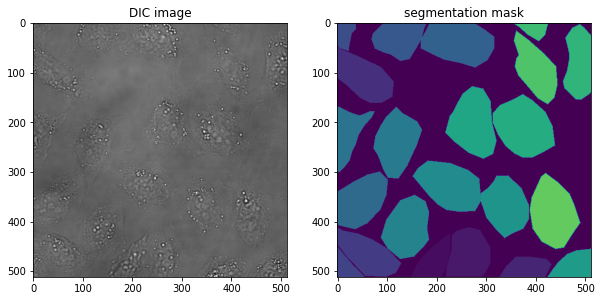

In [7]:
#visualize the images

file_name = '221125_CHO-K_SP1_Hoechst_60x(z2)_6.jpg'
image = np.array(Image.open(eval_path+file_name))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('DIC image')
plt.imshow(image)
plt.subplot(122)
plt.title('segmentation mask')
plt.imshow(instance_masks[file_name])
plt.show()

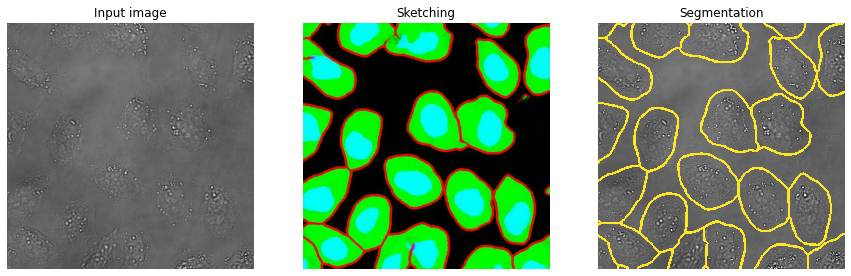

In [8]:
#check cellsketch
weight_path = 'weights/'
#weight filenames
weight_dict = {'Ladv + L1': 'L1_Ladv',
               'L1': 'L1',
               'Ladv': 'Ladv'}

model = cs.CellSketch(weight_path + weight_dict['Ladv + L1'])
seg, nuc_seg, sketch = model.segment(image, show_result=True, remove_small_objects=True, min_size=300)

Ladv + L1


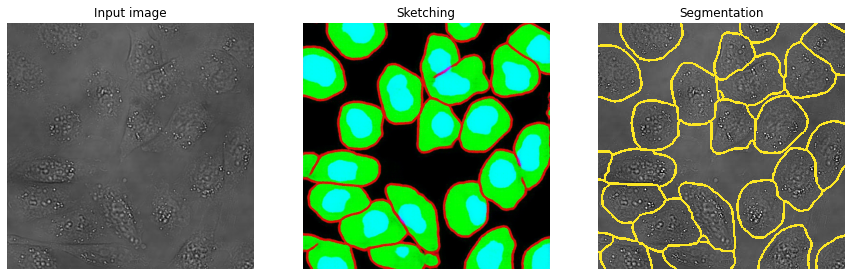

L1


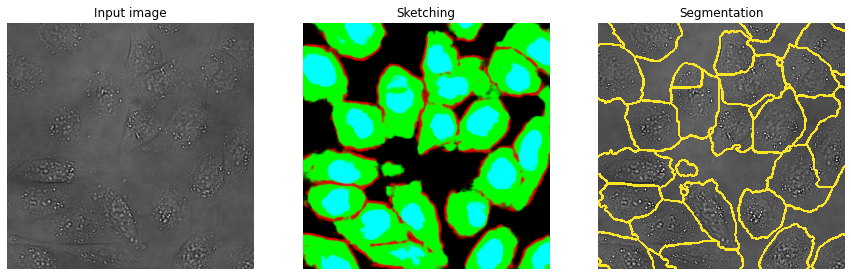

Ladv


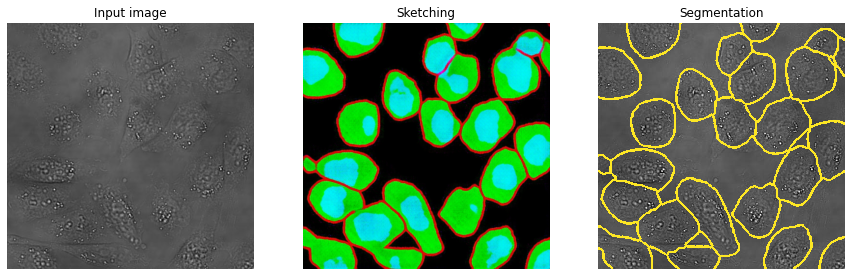

In [9]:
file_name = '221125_CHO-K_SP1_Hoechst_60x(z2)_2.jpg'
image = np.array(Image.open(eval_path+file_name))

for method, weight_name in weight_dict.items():
  print(method)
  model.load_weight(weight_path + weight_name)
  seg, nuc_seg, sketch = model.segment(image, show_result=True, remove_small_objects=True, min_size=300)

#Evaluation

In [10]:
#calculate AP

w_postproc = {} #AP scores with post-processing
wo_postproc = {} #AP scores without post-processing (i.e., green channel mask)
nuc_score = {} #AP scores for nuclei mask

for method, weight_name in tqdm.tqdm(weight_dict.items()):
  
  weight = weight_path + weight_name
  
  model.load_weight(weight)
  
  #scores w/ post-processing
  AP50_w = []
  AP75_w = []

  #scores w/o post-processing
  AP50_wo = []
  AP75_wo = []

  AP50_nuc = []

  for f_n, manual_seg in instance_masks.items():
    #generate RGB images and segmentation masks, seg: cell mask, nuc_seg: nuclei mask, sketch: generated RGB mask
    image = np.array(Image.open(eval_path+f_n))
    seg, nuc_seg, sketch = model.segment(image, remove_small_objects=True, min_size=300)

    #1. calculate AP50 and AP75 of cell mask
    AP, precisions, recalls, overlaps = mAP_from_instances(manual_seg, seg, iou_threshold=0.5)
    AP50_w.append(AP)
    AP, precisions, recalls, overlaps = mAP_from_instances(manual_seg, seg, iou_threshold=0.75)
    AP75_w.append(AP)

    #Get cell mask directly from green channel
    G_mask = utils.binarize(sketch[:,:,1])
    G_mask = utils.clean(G_mask, 6)
    G_mask = label(G_mask)
    #2. calculate AP50 and AP75 of the green mask
    AP, precisions, recalls, overlaps = mAP_from_instances(manual_seg, G_mask, iou_threshold=0.5)
    AP50_wo.append(AP)
    AP, precisions, recalls, overlaps = mAP_from_instances(manual_seg, G_mask, iou_threshold=0.75)
    AP75_wo.append(AP)

    #3. evaluate nuclei segmentation
    #read nuclei mask
    fn = f_n.replace('.jpg', '') + '_mask.npy'
    with open(eval_path + 'Nuclei/' + fn, 'rb') as f:
      nuc_mask = np.load(f)
    AP, precisions, recalls, overlaps = mAP_from_instances(nuc_mask, nuc_seg, iou_threshold=0.5)
    AP50_nuc.append(AP)
  
  w_postproc[method] = {'AP50': AP50_w, 'AP75': AP75_w}
  wo_postproc[method] = {'AP50': AP50_wo, 'AP75': AP75_wo}
  nuc_score[method] = AP50_nuc

100%|██████████| 3/3 [01:12<00:00, 24.01s/it]


#Data Visualization

In [11]:
import matplotlib.font_manager as fm
fm.fontManager.ttflist += fm.createFontList(['Roboto-Regular.ttf'])
plt.rc('font', size=18)
plt.rc('legend', fontsize=13)
plt.rc('font', family='Roboto')
plt.rcParams['mathtext.default'] = 'regular'

<ipython-input-11-2a8d2dc37ea9>:2: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  fm.fontManager.ttflist += fm.createFontList(['Roboto-Regular.ttf'])


In [12]:
methods = ['Ladv + L1', 'L1', 'Ladv']

label_dict = {'Ladv + L1': 'L$_{adv}$ + L$_{L1}$',
               'L1': 'L$_{L1}$',
               'Ladv': 'L$_{adv}$'}

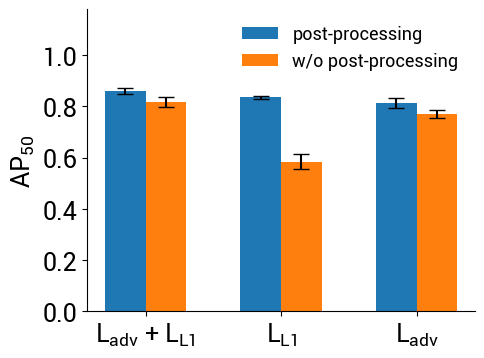

In [13]:
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
x = np.arange(0,3,1)
width = 0.3

data1 = [w_postproc[mtd]['AP50'] for mtd in methods]
data2 = [wo_postproc[mtd]['AP50'] for mtd in methods]

ax.bar(x - width/2, [np.mean(data) for data in data1], width, label='post-processing')
ax.bar(x + width/2, [np.mean(data) for data in data2], width, label='w/o post-processing')
plt.errorbar(x - width/2, [np.mean(data) for data in data1], [np.std(data)/len(data) for data in data1], c='k',
             capsize=6, ls=' ')
plt.errorbar(x + width/2, [np.mean(data) for data in data2], [np.std(data)/len(data) for data in data2], c='k',
             capsize=6, ls=' ')
plt.ylim(0,1.18)
plt.ylabel('AP$_{50}$')
ax.set_xticks(x)
ax.set_xticklabels(label_dict.values())
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.legend(loc='upper right', frameon=False)
plt.show()

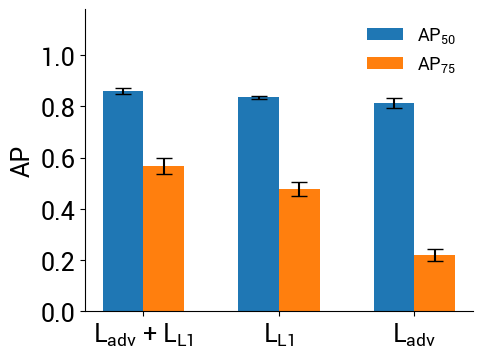

In [14]:
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
x = np.arange(0,3,1)
width = 0.3

data1 = [w_postproc[mtd]['AP50'] for mtd in methods]
data2 = [w_postproc[mtd]['AP75'] for mtd in methods]

ax.bar(x - width/2, [np.mean(data) for data in data1], width, label='AP$_{50}$')
ax.bar(x + width/2, [np.mean(data) for data in data2], width, label='AP$_{75}$')
plt.errorbar(x - width/2, [np.mean(data) for data in data1], [np.std(data)/len(data) for data in data1], c='k',
             capsize=6, ls=' ')
plt.errorbar(x + width/2, [np.mean(data) for data in data2], [np.std(data)/len(data) for data in data2], c='k',
             capsize=6, ls=' ')
plt.ylim(0,1.18)
plt.ylabel('AP')
ax.set_xticks(x)
ax.set_xticklabels(label_dict.values())
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.legend(loc='upper right', frameon=False)
plt.show()

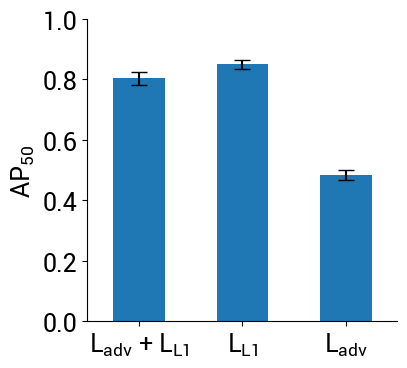

In [15]:
fig, ax = plt.subplots(figsize=(4,4), dpi=100)
x = np.arange(0,3,1)
width = 0.5

data1 = [nuc_score[mtd] for mtd in methods]

plt.bar(x, [np.mean(data) for data in data1], width)
plt.errorbar(x, [np.mean(data) for data in data1], [np.std(data)/len(data) for data in data1], c='k',
             capsize=6, ls=' ')
plt.ylim(0,1.0)
plt.xlim(-0.5,2.5)
plt.ylabel('AP$_{50}$')
ax.set_xticks(x)
ax.set_xticklabels(label_dict.values())
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

Ladv + L1


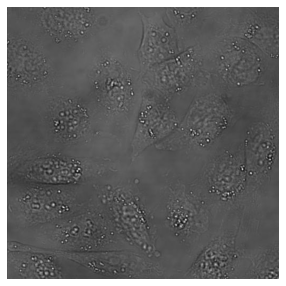

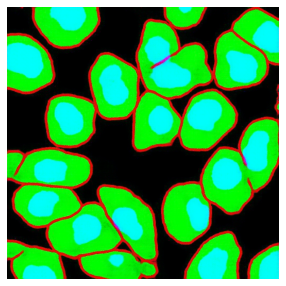

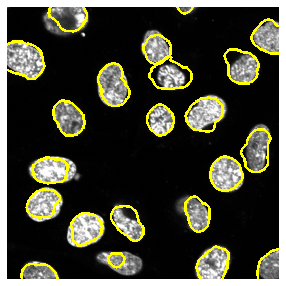

L1


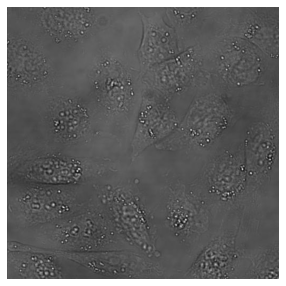

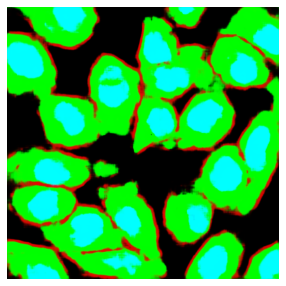

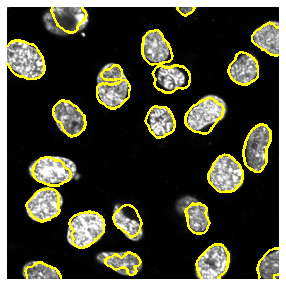

Ladv


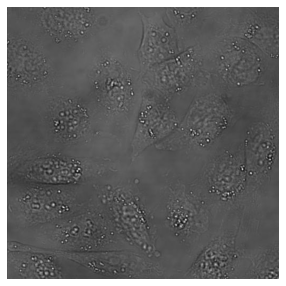

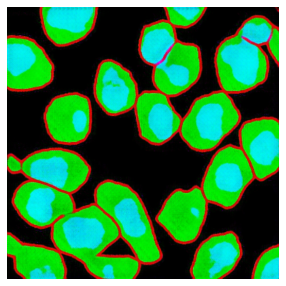

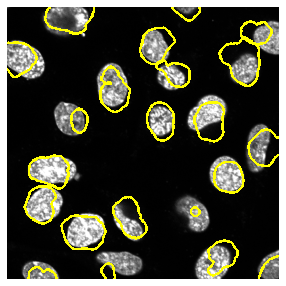

In [16]:
file_name = '221125_CHO-K_SP1_Hoechst_60x(z2)_2.jpg'
image = np.array(Image.open(eval_path+file_name))

for method, weight_name in weight_dict.items():
  print(method)
  model.load_weight(weight_path + weight_name)
  seg, nuc_seg, sketch = model.segment(image)

  fn = file_name.replace('.jpg', '') + '_fl.npy'
  with open(eval_path + 'Nuclei/' + fn, 'rb') as f:
    nuc_fl = np.load(f)
  
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  plt.figure(figsize=(5,5))
  plt.imshow(sketch)
  plt.axis('off')
  plt.show()
  plt.figure(figsize=(5,5))
  plt.imshow(nuc_fl, cmap='gray')
  utils.overlay_mask(utils.get_edge(nuc_seg), cmap='gnuplot_r')
  plt.axis('off')
  plt.show()